In [220]:
import pandas as pd
import numpy as np
import pickle as pkl
import os, gc, math, sys, re
import os,sys
import numpy as np
import logging
import pandas as pd
import time

from tqdm import *
from datetime import datetime as dt
from datetime import datetime, timedelta
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool
from sklearn.cluster import KMeans
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [221]:
log_filename = format(dt.today(), 'log_research-%Y-%m-%d.log')
logging.basicConfig(format='[%(asctime)s]  %(message)s', level=logging.DEBUG,
                    filename=os.path.join('..', log_filename))
logging.info('RESEARCH log file')

In [222]:
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
matplotlib.rc('font', family='DejaVu Sans')
%matplotlib inline

In [223]:
with open('../preproc_df.pkl', 'rb') as f:
    df = pkl.load(f)

In [224]:
def show_nulls(data):
    d = ((c, data[c][pd.isnull(data[c])].shape[0]) for c in data.columns)
    return pd.DataFrame(d, columns=['name', 'nans'])

In [225]:
def mape(y_true, y_pred):
    x = list(filter(lambda x: x[0] != 0, zip(y_true, y_pred)))
    y_true = [i[0] for i in x]
    y_pred = [i[1] for i in x]
    return np.mean(np.abs((pd.Series(y_true) - pd.Series(y_pred)) / pd.Series(y_true))) * 100

def quality(true,pred):
    res_df = pd.DataFrame()
    res_df['true'] = true
    res_df['pred'] = pred
    res_df['t-p'] = res_df['true'] - res_df['pred']
    res_df['t-p'] = list(map(lambda x: abs(x), res_df['t-p']))
    res_df = res_df[res_df['true'] != 0]
    return np.mean(res_df['t-p'])/np.mean(res_df['true'])

    

In [226]:
features = list(df.columns[14:19]) + list(df.columns[22:])
target = 'time_of_expected'

In [227]:
print min(df.Arrive), ' - ', max(df.Arrive)
print min(df[map(lambda x: x.year == 2015, df.Arrive)].Arrive), ' - ', max(df[map(lambda x: x.year == 2015, df.Arrive)].Arrive)
print min(df[map(lambda x: x.year != 2015, df.Arrive)].Arrive), ' - ', max(df[map(lambda x: x.year != 2015, df.Arrive)].Arrive)

2014-04-07 06:48:00  -  2016-11-16 16:20:49
2015-01-02 06:58:00  -  2015-04-10 17:49:00
2014-04-07 06:48:00  -  2016-11-16 16:20:49


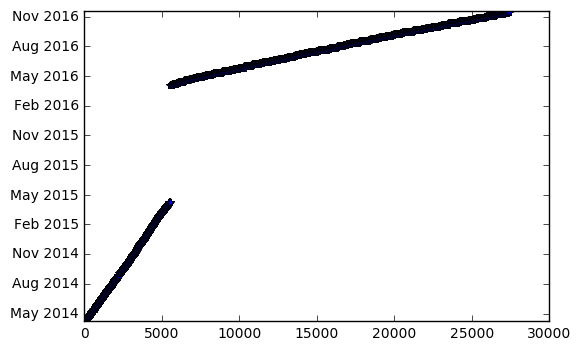

In [228]:
plt.plot(range(df.shape[0]), sorted(df.Arrive), '*')

In [229]:
df = df.sort_values('time_of_expected')
df = df[5:df.shape[0]-5]

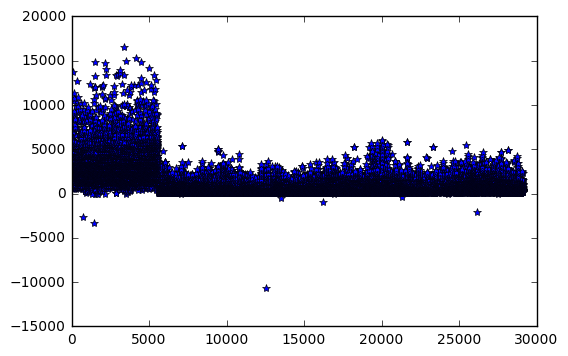

In [230]:
plt.plot(df.time_of_expected, '*')

In [231]:
date_threshold_val_low_1 = datetime.strptime('15.03.2015','%d.%m.%Y')
date_threshold_val_up_1 = datetime.strptime('01.04.2015','%d.%m.%Y')

date_threshold_val_low_2 = datetime.strptime('01.10.2016','%d.%m.%Y')
date_threshold_val_up_2 = datetime.strptime('01.11.2016','%d.%m.%Y')

date_threshold_test_low_1 = datetime.strptime('02.04.2015','%d.%m.%Y')
date_threshold_test_up_1 = datetime.strptime('15.08.2015','%d.%m.%Y')

date_threshold_test_low_2 = datetime.strptime('02.11.2016','%d.%m.%Y')
date_threshold_test_up_2 = datetime.strptime('21.01.2017','%d.%m.%Y')

val_cond = ( (df.Arrive >= date_threshold_val_low_1) & (df.Arrive <= date_threshold_val_up_1) )\
            |\
            ( (df.Arrive >= date_threshold_val_low_2) & (df.Arrive <= date_threshold_val_up_2))
test_cond = ( (df.Arrive >= date_threshold_test_low_1) & (df.Arrive <= date_threshold_test_up_1) )\
            |\
            ( (df.Arrive >= date_threshold_test_low_2) & (df.Arrive <= date_threshold_test_up_2))

test = df[test_cond]        
val = df[val_cond]
train = df[map(lambda x,y: not (x or y), test_cond, val_cond)]

In [232]:
print train.shape[0]
print val.shape[0]
print test.shape[0]

22529
3371
1514


#### Реализуем такие методы, как
##### - последовательное добавление признаков
##### - последовательное вычитание признаков
##### для таких моделей, как LR, LR(Lasso, Ridge), XGBoost, RandomForest

In [233]:
class AddFeatures(BaseEstimator, RegressorMixin):
    
    def __init__(self, model, stop=False):
        self.model = model
        self.features = []
        self.score = [sys.float_info.max]
        self.final_model = None
        self.stop = stop
        logging.info(self.model.__class__)
    
    def fit(self, df, df_val, features, target, score):
        # score: less -> better
        
        self.all_features = features
        self.flag_stop = True
        while self.flag_stop and self.all_features:
            res = []
            for feat in self.all_features:
                model = self.model
                model.fit(df[self.features + [feat]],df[target])
                y_pred = model.predict(df_val[self.features + [feat]])
                y_real = df_val[target]
                temp_score = score(y_real, y_pred)
                res.append((feat, temp_score, ))
            
            res_sorted = sorted(res, key=lambda x: x[1])  
            
            logging.info('{} - {}'.format(res_sorted[0][0],res_sorted[0][1]))
            
            if res_sorted[0][1] < self.score[-1]:
                self.all_features.remove(res_sorted[0][0])
                self.features.append(res_sorted[0][0])
                self.score.append(res_sorted[0][1])
            else:
                if self.stop:
                    self.flag_stop = False
                else:
                    self.all_features.remove(res_sorted[0][0])
                    self.features.append(res_sorted[0][0])
                    self.score.append(res_sorted[0][1])
    
    def predict(self, df_test):
        pred = self.final_model.predict(df_test[self.features])
        return pred

In [234]:
models = [AddFeatures(LinearRegression()),
         AddFeatures(Lasso()),
         AddFeatures(Ridge()),
         AddFeatures(ElasticNet()),
         AddFeatures(RandomForestRegressor()),
         AddFeatures(xgb.XGBRegressor()),
         ]

In [236]:
fit_models_r2 = []
for m in models:
    temp_model = m
    temp_model.fit(train, val, features, target, lambda x,y: -r2_score(x,y))
    fit_models_r2.append(temp_model)

In [237]:
fit_models_mape = []
for m in models:
    temp_model = m
    temp_model.fit(train, val, features, target, lambda x,y: mape(x,y))
    fit_models_mape.append(temp_model)

In [239]:
model = fit_models_r2[0]

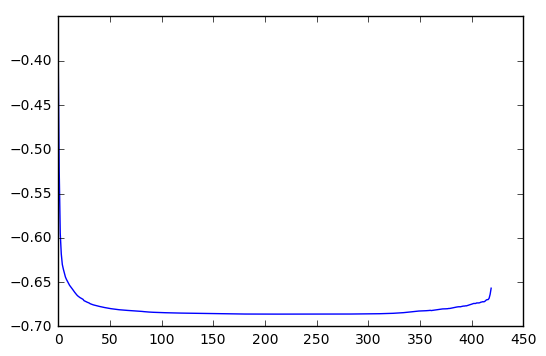

In [244]:
plt.plot(model.score[1:-3])